In [18]:
import os
import sys
import glob
import tempfile
from math import sqrt, pi, atan2, log, pow, cos, log, exp

import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from pesq import pesq
from pysiib import SIIB

repos_dir = r'/home/akikun/repos'
sys.path.append(repos_dir)
from sak import display as dp
from sak import signal_processing as sp
from sak import nele

import IPython.display
from IPython.display import display
import librosa.display

In [2]:
def load_wav(wav_path, sampling_frequency=16000):
    x, sr = librosa.load(wav_path, sr=None)
    if not sr == 16000:
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.wav')
        temp_file.close()
        #wav_16k_path = wav_path.replace('.wav', '_16k.wav')
        sp.change_sample_bit_rate(wav_path, temp_file.name, sample_rate=16000)
        x = sp.load_wav(temp_file.name, sampling_rate=sampling_frequency)
        os.remove(temp_file.name)
    return x

def pesq2mos(pesq):
    """ Return MOS LQO value (within 1..4.5) on PESQ value (within -0.5..4.5).
    Mapping function given from P.862.1 (11/2003) """
    return 0.999 + (4.999-0.999) / (1+exp(-1.4945*pesq+4.6607))


main_dir = r'/home/akikun/Projects/nele/jr_demo/20210406'
speaker = 'sayaka'
noise_nr = 1
snr = -10
wav_clean_path  = os.path.join(main_dir,                        
                'clean', speaker + '.wav')
wav_imgan_path = os.path.join(main_dir, 
                'imgan2', 'rms002_44k', speaker + '.wav')
wav_noise_path  = os.path.join(main_dir, 
                'add_noise', 
                'noise', 
                speaker + '_noise' + str(noise_nr) + '_snr' + str(snr) + '.wav')
wav_mixed_clean_path  = os.path.join(main_dir, 
                'add_noise', 
                'mixed', 
                speaker + '_clean_noise' + str(noise_nr) + '_snr' + str(snr) + '.wav')
wav_mixed_imgan_path  = os.path.join(main_dir, 
                'add_noise', 
                'mixed', 
                speaker + '_imgan2_noise' + str(noise_nr) + '_snr' + str(snr) + '.wav')
sampling_frequency = 44100

In [3]:
# print('clean: {} (exists:{})'.format(wav_clean_path, os.path.exists(wav_clean_path)))
# print('imgan: {} (exists:{})'.format(wav_imgan_path, os.path.exists(wav_imgan_path)))
# print('noise: {} (exists:{})'.format(wav_noise_path, os.path.exists(wav_noise_path)))
# print('mixed_clean: {} (exists:{})'.format(wav_mixed_clean_path, os.path.exists(wav_mixed_clean_path)))
# print('mixed_imgan: {} (exists:{})'.format(wav_mixed_imgan_path, os.path.exists(wav_mixed_imgan_path)))

clean: /home/akikun/Projects/nele/jr_demo/20210406/clean/sayaka.wav (exists:True)
imgan: /home/akikun/Projects/nele/jr_demo/20210406/imgan2/rms002_44k/sayaka.wav (exists:True)
noise: /home/akikun/Projects/nele/jr_demo/20210406/add_noise/noise/sayaka_noise1_snr-10.wav (exists:True)
mixed_clean: /home/akikun/Projects/nele/jr_demo/20210406/add_noise/mixed/sayaka_clean_noise1_snr-10.wav (exists:True)
mixed_imgan: /home/akikun/Projects/nele/jr_demo/20210406/add_noise/mixed/sayaka_imgan2_noise1_snr-10.wav (exists:True)


In [4]:
# # check the wav length.
# for wav_path in [wav_clean_path, wav_imgan_path, wav_noise_path, wav_mixed_clean_path, wav_mixed_imgan_path]:
#     print('{} (exists:{})'.format(wav_path, os.path.exists(wav_path)))
#     x, sr = librosa.load(wav_path, sr=None)
#     print('length:{}'.format(np.shape(x)))
#     print('sampling_rate:{}'.format(sr))
    
x_clean = sp.load_wav(wav_clean_path)
x_imgan = sp.load_wav(wav_imgan_path)
x_noise = sp.load_wav(wav_noise_path)
x_mixed_clean = sp.load_wav(wav_mixed_clean_path)
x_mixed_imgan = sp.load_wav(wav_mixed_imgan_path)

# adjust the length.
min_len = min(len(x_clean), len(x_imgan), len(x_noise), len(x_mixed_clean), len(x_mixed_imgan))
x_clean = x_clean[0:min_len]
x_imgan = x_imgan[0:min_len]
x_noise = x_noise[0:min_len]
x_mixed_clean = x_mixed_clean[0:min_len]
x_mixed_imgan = x_mixed_imgan[0:min_len]

/home/akikun/Projects/nele/jr_demo/20210406/clean/sayaka.wav (exists:True)
length:(1336798,)
sampling_rate:44100
/home/akikun/Projects/nele/jr_demo/20210406/imgan2/rms002_44k/sayaka.wav (exists:True)
length:(1336406,)
sampling_rate:44100
/home/akikun/Projects/nele/jr_demo/20210406/add_noise/noise/sayaka_noise1_snr-10.wav (exists:True)
length:(1336798,)
sampling_rate:44100
/home/akikun/Projects/nele/jr_demo/20210406/add_noise/mixed/sayaka_clean_noise1_snr-10.wav (exists:True)
length:(1336798,)
sampling_rate:44100
/home/akikun/Projects/nele/jr_demo/20210406/add_noise/mixed/sayaka_imgan2_noise1_snr-10.wav (exists:True)
length:(1336406,)
sampling_rate:44100


In [6]:
x_clean_16 = load_wav(wav_clean_path)
x_noise_16 = load_wav(wav_noise_path)
x_imgan_16 = load_wav(wav_imgan_path)
x_quiet_16 = np.ones((np.size(x_noise)))*0.00000001

# clean
siib_score = SIIB(x_clean, x_clean, sampling_frequency, gauss=True)
pesq_score = pesq(16000, x_clean_16, x_quiet_16, 'wb')
print('original: siib {:.3f}, pesq {:.3f} (MOS: {:.3f})'.format(siib_score, pesq_score, pesq2mos(pesq_score)))

# clean + noise.
siib_score = SIIB(x_clean, x_mixed_clean, sampling_frequency, gauss=True)
pesq_score = pesq(16000, x_clean_16, x_noise_16, 'wb')
print('clean + noise: siib {:.3f}, pesq {:.3f} (MOS: {:.3f})'.format(siib_score, pesq_score, pesq2mos(pesq_score)))

# clean + imgan
siib_score = SIIB(x_imgan, x_mixed_imgan, sampling_frequency, gauss=True)
pesq_score = pesq(16000, x_imgan_16, x_noise_16, 'wb')
print('imgan + noise: siib {:.3f}, pesq {:.3f} (MOS: {:.3f})'.format(siib_score, pesq_score, pesq2mos(pesq_score)))


original: siib 1335.762, pesq 1.173 (MOS: 1.206)
clean + noise: siib 18.371, pesq 1.041 (MOS: 1.171)
imgan + noise: siib 79.729, pesq 1.416 (MOS: 1.290)


## figures

In [10]:
scores = []
for snr in [0, -5, -8, -10]:
    wav_noise_path  = os.path.join(main_dir, 
                    'add_noise', 
                    'noise', 
                    speaker + '_noise' + str(noise_nr) + '_snr' + str(snr) + '.wav')
    wav_mixed_clean_path  = os.path.join(main_dir, 
                    'add_noise', 
                    'mixed', 
                    speaker + '_clean_noise' + str(noise_nr) + '_snr' + str(snr) + '.wav')
    wav_mixed_imgan_path  = os.path.join(main_dir, 
                    'add_noise', 
                    'mixed', 
                    speaker + '_imgan2_noise' + str(noise_nr) + '_snr' + str(snr) + '.wav')


    # adjust the length.
    x_clean = sp.load_wav(wav_clean_path)
    x_imgan = sp.load_wav(wav_imgan_path)
    x_noise = sp.load_wav(wav_noise_path)
    x_mixed_clean = sp.load_wav(wav_mixed_clean_path)
    x_mixed_imgan = sp.load_wav(wav_mixed_imgan_path)

    min_len = min(len(x_clean), len(x_imgan), len(x_noise), len(x_mixed_clean), len(x_mixed_imgan))
    x_clean = x_clean[0:min_len]
    x_imgan = x_imgan[0:min_len]
    x_noise = x_noise[0:min_len]
    x_mixed_clean = x_mixed_clean[0:min_len]
    x_mixed_imgan = x_mixed_imgan[0:min_len]

    x_clean_16 = load_wav(wav_clean_path)
    x_noise_16 = load_wav(wav_noise_path)
    x_imgan_16 = load_wav(wav_imgan_path)
    x_quiet_16 = np.ones((np.size(x_noise)))*0.00000001


    # clean
    siib_score = SIIB(x_clean, x_clean, sampling_frequency, gauss=True)
    pesq_score = pesq(16000, x_clean_16, x_quiet_16, 'wb')
    print('original: siib {:.3f}, pesq {:.3f} (MOS: {:.3f})'.format(siib_score, pesq_score, pesq2mos(pesq_score)))
    scores.append([snr, 0, siib_score, pesq_score])
    
    # clean + noise.
    siib_score = SIIB(x_clean, x_mixed_clean, sampling_frequency, gauss=True)
    pesq_score = pesq(16000, x_clean_16, x_noise_16, 'wb')
    print('clean + noise: siib {:.3f}, pesq {:.3f} (MOS: {:.3f})'.format(siib_score, pesq_score, pesq2mos(pesq_score)))
    scores.append([snr, 1, siib_score, pesq_score])
    
    # clean + imgan
    siib_score = SIIB(x_imgan, x_mixed_imgan, sampling_frequency, gauss=True)
    pesq_score = pesq(16000, x_imgan_16, x_noise_16, 'wb')
    print('imgan + noise: siib {:.3f}, pesq {:.3f} (MOS: {:.3f})'.format(siib_score, pesq_score, pesq2mos(pesq_score)))
    scores.append([snr, 2, siib_score, pesq_score])
df = pd.DataFrame(scores, columns = ['snr', 'type', 'siib', 'pesq'])

original: siib 1335.762, pesq 1.173 (MOS: 1.206)
clean + noise: siib 91.054, pesq 1.041 (MOS: 1.171)
imgan + noise: siib 236.623, pesq 1.326 (MOS: 1.256)
original: siib 1335.762, pesq 1.172 (MOS: 1.206)
clean + noise: siib 44.498, pesq 1.041 (MOS: 1.171)
imgan + noise: siib 146.954, pesq 1.327 (MOS: 1.256)
original: siib 1335.762, pesq 1.173 (MOS: 1.206)
clean + noise: siib 26.786, pesq 1.041 (MOS: 1.171)
imgan + noise: siib 104.054, pesq 1.294 (MOS: 1.245)
original: siib 1335.762, pesq 1.173 (MOS: 1.206)
clean + noise: siib 18.371, pesq 1.041 (MOS: 1.171)
imgan + noise: siib 79.729, pesq 1.331 (MOS: 1.258)


In [37]:
scores_original = df[df['type']==0]
scores_clean = df[df['type']==1]
scores_imgan = df[df['type']==2]
scores

[[0, 0, 1335.7624872954837, 1.1727949380874634],
 [0, 1, 91.05435913816281, 1.0413072109222412],
 [0, 2, 236.62320038863686, 1.325716257095337],
 [-5, 0, 1335.7624872954837, 1.1724098920822144],
 [-5, 1, 44.49753838103982, 1.0410770177841187],
 [-5, 2, 146.95382764030828, 1.3271384239196777],
 [-8, 0, 1335.7624872954837, 1.172502040863037],
 [-8, 1, 26.78606410051843, 1.0413278341293335],
 [-8, 2, 104.0538856205617, 1.2942171096801758],
 [-10, 0, 1335.7624872954837, 1.173405647277832],
 [-10, 1, 18.370807059670994, 1.0413296222686768],
 [-10, 2, 79.72919518535178, 1.3308115005493164]]

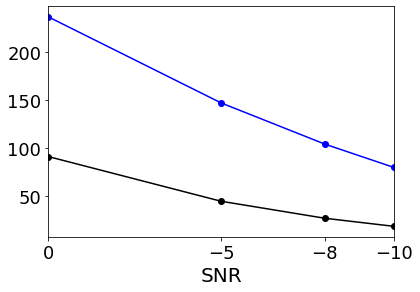

In [40]:
snrs = [0, -5, -8, -10]
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
#ax.plot(snrs, np.array(scores_original['siib']), 'ko--', label='original')
ax.plot(snrs, np.array(scores_clean['siib']), 'ko-', label='audio + noise')
ax.plot(snrs, np.array(scores_imgan['siib']), 'bo-', label='audio(NELE) + noise')
#plt.plot(snrs, np.array(scores_ssdrc)[:, 1], 'kx--', label='SSDRC')
plt.xlabel('SNR', fontsize=20)
#plt.ylabel('SIIB', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=18)
#plt.legend()
plt.xlim([0, -10])
ax.set_xticks([0, -5, -8, -10])
fig.savefig(os.path.join(main_dir, 'siib.png'))

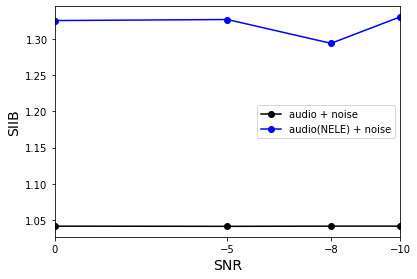

In [36]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
#ax.plot(snrs, np.array(scores_original['siib']), 'ko--', label='original')
ax.plot(snrs, np.array(scores_clean['pesq']), 'ko-', label='audio + noise')
ax.plot(snrs, np.array(scores_imgan['pesq']), 'bo-', label='audio(NELE) + noise')
#plt.plot(snrs, np.array(scores_ssdrc)[:, 1], 'kx--', label='SSDRC')
plt.xlabel('SNR', fontsize=14)
plt.ylabel('SIIB', fontsize=14)
plt.legend()
plt.xlim([0, -10])
ax.set_xticks([0, -5, -8, -10])
#fig.savefig(os.path.join(main_dir, 'siib.png'))